## Cal-CRAI Metric Calculation for: Climate Risk / Floodplains
* percentage of a tract in a 100 year floodplain area

In [1]:
import pandas as pd
import os
import sys
import boto3
import io
import geopandas as gpd

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_gpkg_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata

In [2]:
# make a list of paths, since this is actually 10 files
def climate_floodplain_pull(
    path='2b_reproject/climate_risk/flood/exposure/koordinates/climate_koordinates_floodplain.parquet.gzip'
):
    """ Build a list of shapefile URIs contained in S3 folder """
    # initiate empty list for s3 URIs
    all_shapefiles = []
    bucket_name = 'ca-climate-index' 
    # initiate s3 session
    session = boto3.Session()
    # use the session to get the resource
    s3 = session.resource('s3')
    my_bucket = s3.Bucket(bucket_name)
    # iterate through directory
    for obj in my_bucket.objects.filter(
        Prefix=path):
        all_shapefiles.append(obj.key)
    return all_shapefiles

In [3]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '2b_reproject/climate_risk/flood/exposure/koordinates/'

pull_gpkg_from_directory(bucket_name, aws_dir)

Saved GeoPackage as 'climate_koordinates_floodplain.gpkg' locally


In [4]:
floodplain_data = gpd.read_file('climate_koordinates_floodplain.gpkg')

In [5]:
floodplain_data.head()

,USCB_GEOID,FLD_ZONE,FloodZone,USCB_STATEFP,USCB_COUNTYFP,USCB_TRACTCE,USCB_NAME,USCB_NAMELSAD,USCB_MTFCC,USCB_FUNCSTAT,USCB_ALAND,USCB_AWATER,USCB_INTPTLAT,USCB_INTPTLON,geometry
0,06001400700,AE,100,06,001,400700,4007,Census Tract 4007,G5020,S,865752,0,+37.8417021,-122.2722661,"POLYGON ((-122.27555 37.83658, -122.27547 37.8..."
1,06001401000,AE,100,06,001,401000,4010,Census Tract 4010,G5020,S,1149000,0,+37.8312043,-122.2718866,"POLYGON ((-122.26758 37.83554, -122.26743 37.8..."
2,06001403302,AE,100,06,001,403302,4033.02,Census Tract 4033.02,G5020,S,719239,104126,+37.7937603,-122.2667344,"MULTIPOLYGON (((-122.27307 37.79199, -122.2728..."
3,06001403401,AO,100,06,001,403401,4034.01,Census Tract 4034.01,G5020,S,549686,602434,+37.8092493,-122.2597833,"POLYGON ((-122.25947 37.79857, -122.25952 37.7..."
4,06001403501,A,100,06,001,403501,4035.01,Census Tract 4035.01,G5020,S,669873,0,+37.8177398,-122.2600504,"POLYGON ((-122.25886 37.81999, -122.25890 37.8..."


In [6]:
floodplain_data.FloodZone.unique()

array(['100'], dtype=object)

<Axes: >

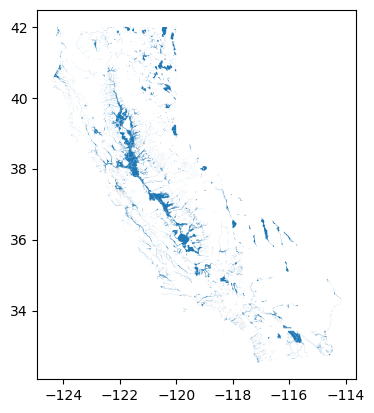

In [7]:
floodplain_data.plot()

In [8]:
# selecting relevant columns for processing
selected_columns = ['USCB_GEOID', 'FloodZone', 'geometry']

floodplain_columns = floodplain_data[selected_columns]

one_hundred_yr_floodplain_drop_duplicates = floodplain_columns.drop_duplicates(['geometry'], keep='first')
one_hundred_yr_floodplain_drop_duplicates

,USCB_GEOID,FloodZone,geometry
0,06001400700,100,"POLYGON ((-122.27555 37.83658, -122.27547 37.8..."
1,06001401000,100,"POLYGON ((-122.26758 37.83554, -122.26743 37.8..."
2,06001403302,100,"MULTIPOLYGON (((-122.27307 37.79199, -122.2728..."
3,06001403401,100,"POLYGON ((-122.25947 37.79857, -122.25952 37.7..."
4,06001403501,100,"POLYGON ((-122.25886 37.81999, -122.25890 37.8..."
...,...,...,...
4833,06115040902,100,"MULTIPOLYGON (((-121.35602 39.07985, -121.3549..."
4834,06115041001,100,"MULTIPOLYGON (((-121.62633 39.20120, -121.6261..."
4835,06115041002,100,"MULTIPOLYGON (((-121.44474 39.33174, -121.4445..."
4836,06115041101,100,"MULTIPOLYGON (((-121.37025 39.36828, -121.3704..."


In [9]:
# Count the total number of duplicates in the geometry column
duplicate_count = one_hundred_yr_floodplain_drop_duplicates.duplicated(subset=['geometry']).sum()

print(f"Number of dropped duplicate geometries: {duplicate_count}")

Number of dropped duplicate geometries: 0


In [10]:
# read in CA census tiger file
ca_tract_county = "s3://ca-climate-index/0_map_data/ca_tracts_county.csv"
ca_tract_county = gpd.read_file(ca_tract_county)
ca_tract_county = ca_tract_county.drop(columns={'field_1'})
ca_tract_county.columns = ca_tract_county.columns.str.lower()
ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)
ca_tract_county = ca_tract_county.drop(columns='geometry')

C:\Users\jespi\AppData\Local\Temp\ipykernel_29232\3204430966.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ca_tract_county = ca_tract_county.applymap(lambda s: s.lower() if type(s) == str else s)


In [11]:
# read in CA spatial census tiger file
census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries = ca_boundaries[['GEOID', 'geometry']]
ca_boundaries = ca_boundaries.rename(columns={'GEOID':'tract'})

In [12]:
# merge the two CA tract datasets together
ca_tract_county_spatial = pd.merge(ca_tract_county, ca_boundaries, on='tract', how='left')
ca_tract_county_spatial = ca_tract_county_spatial.rename(columns={'tract':'USCB_GEOID'})
ca_tract_county_spatial

,USCB_GEOID,countyfp,county,geometry
0,06085504321,085,santa clara,"POLYGON ((-121.87556 37.39924, -121.87535 37.3..."
1,06085504410,085,santa clara,"POLYGON ((-121.88886 37.40758, -121.88576 37.4..."
2,06085507003,085,santa clara,"POLYGON ((-122.02489 37.21683, -122.02459 37.2..."
3,06085507004,085,santa clara,"POLYGON ((-121.99304 37.22562, -121.99249 37.2..."
4,06085502204,085,santa clara,"POLYGON ((-121.93167 37.29803, -121.92801 37.3..."
...,...,...,...,...
9124,06059001303,059,orange,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
9125,06059001304,059,orange,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
9126,06059001401,059,orange,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."
9127,06013367200,013,contra costa,"POLYGON ((-122.34551 37.96355, -122.34550 37.9..."


In [13]:
geo_ca_tract_county = gpd.GeoDataFrame(ca_tract_county_spatial)

In [14]:
# Step 1: Check the CRS
print("Initial CRS of protected areas:", one_hundred_yr_floodplain_drop_duplicates.crs)
print("Initial CRS of CA tract/counties dataset:", geo_ca_tract_county.crs)

# Step 2: Reproject to an appropriate CRS for area calculations
gdf1 = one_hundred_yr_floodplain_drop_duplicates.to_crs(epsg=3310)  # California Albers
gdf2 = geo_ca_tract_county.to_crs(epsg=3310)  # California Albers

print("Reprojected CRS of cnra protected areas:", gdf1.crs)
print("Reprojected CRS of Counties:", gdf2.crs)

# Check for and fix invalid geometries in both GeoDataFrames
gdf1['geometry'] = gdf1['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)
gdf2['geometry'] = gdf2['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)

# Verify if all geometries are now valid
print("Protected areas geometries valid:", gdf1.is_valid.all())
print("County geometries valid:", gdf2.is_valid.all())

# Step 3: Calculate the total area of floodplain areas per tract
floodplain_area_tract = gdf1.dissolve(by='USCB_GEOID', aggfunc='sum')['geometry'].area.reset_index(name='floodplain_tract_area')

# Step 4: Calculate the total area of each tract
tract_area = gdf2.dissolve(by='USCB_GEOID', aggfunc='sum')['geometry'].area.reset_index(name='tract_area')

# Step 5: Merge the two datasets on the tract column
merged_df = pd.merge(tract_area, floodplain_area_tract, on='USCB_GEOID', how='left')

# Step 6: Calculate the spatial percentage of floodplains per tract
merged_df['floodplain_percentage'] = (merged_df['floodplain_tract_area'] / merged_df['tract_area']) * 100  

# Round the percentages to two decimal places
merged_df['floodplain_percentage'] = merged_df['floodplain_percentage'].round(2)

# Display the results where the percentage exceeds 100 for further investigation
over_100_percent = merged_df[merged_df['floodplain_percentage'] > 100]
print('number of entries over 100 percent:', len(over_100_percent))

Initial CRS of protected areas: EPSG:4269
Initial CRS of CA tract/counties dataset: EPSG:4269
Reprojected CRS of cnra protected areas: EPSG:3310
Reprojected CRS of Counties: EPSG:3310
Protected areas geometries valid: True
County geometries valid: True
number of entries over 100 percent: 0


In [15]:
merged_df.floodplain_percentage.mean()

12.194365440264573

In [16]:
merged_df

,USCB_GEOID,tract_area,floodplain_tract_area,floodplain_percentage
0,06001400100,6.945851e+06,NaN,NaN
1,06001400200,5.865583e+05,NaN,NaN
2,06001400300,1.110836e+06,NaN,NaN
3,06001400400,7.161367e+05,NaN,NaN
4,06001400500,5.914232e+05,NaN,NaN
...,...,...,...,...
9124,06115040902,9.384312e+07,1.853259e+04,0.02
9125,06115041001,2.776416e+08,1.260910e+08,45.42
9126,06115041002,1.976832e+08,1.177561e+07,5.96
9127,06115041101,4.814353e+08,1.591579e+06,0.33


In [17]:
merged_df.to_csv('climate_floodplain_areas_metric.csv')

## Function Call

In [18]:
@append_metadata
def floodplain_areas_upload(input_csv, export=False, varname=''):
    '''
    Uploads the floodplain areas metric to S3 bucket. The metric is:
    
    * % of tract in 100 year floodplain area

    Data for this metric was sourced from the Koordinates at:
    https://koordinates.com/layer/96056-california-fema-100-year-floodplains/

    Methods
    -------
    Relevant data columns were isolated.
    One hundred year floodplain entries were filtered for.
    Data was reprojected to match California tract data.
    Using both datasets 'geometry' columns, a total area column for each tract entry was calculated.
    Estimated floodplain tract percentage was calculated by dividing estimated tract floodplain land
    by estimated total tract area.
    These values were rounded to the nears hundredths to eliminate 18 instances of being >100%.
    
    Parameters
    ----------
    input_csv: string
        csv floodplain areas metric data 
    export: True/False boolean
        False = will not upload resulting df containing CAL CRAI floodplain areas metric to AWS
        True = will upload resulting df containing CAL CRAI floodplain areas metric to AWS

    Script
    ------
    climate_floodplain.ipynb

    Note:
    This function assumes users have configured the AWS CLI such that their access key / secret key pair are stored in ~/.aws/credentials.
    See https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html for guidance.
    '''
    print('Data transformation: relevant columns were isolated and renamed.')
    print('Data transformation: data reprojected to epsg 3310.')
    print('Data transformation: a new column was created to estimate percentage of each tract with management practices.')

    if export == True:
        bucket_name = 'ca-climate-index'
        directory = '3_fair_data/index_data'
        export_filename = [input_csv]
        upload_csv_aws(export_filename, bucket_name, directory)

    if export == False:
        print(f'{input_csv} uploaded to AWS.')
 
    '''if os.path.exists(input_csv):
        os.remove(input_csv)'''

In [19]:
input_csv = 'climate_floodplain_areas_metric.csv'
variable = 'climate_koordinates_floodplain'

floodplain_areas_upload(input_csv, varname=variable, export=False)